<a href="https://colab.research.google.com/github/summerolmstead/Sales-Prediction/blob/main/Pizza_Sales_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Team Project | Pizza Prediction Sales

Summer, Jason, Victoria, Regan

#Importing Data in

In [178]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rhonarosecortez/pizza-sales-dataset") #importing from kaggle

print("Path to dataset files:", path) # path to the file

Path to dataset files: /root/.cache/kagglehub/datasets/rhonarosecortez/pizza-sales-dataset/versions/2


In [179]:
import os
dataset_files = os.listdir(path)
print("Dataset files:", dataset_files)

Dataset files: ['Pizza Sales Dataset.csv']


In [180]:
import pandas as pd
csv_file_path = os.path.join(path, 'Pizza Sales Dataset.csv')
df = pd.read_csv(csv_file_path)

print(df.head()) # seeing structure of data

   pizza_id  order_id  pizza_name_id  quantity order_date order_day  \
0         1         1     hawaiian_m         1   1/1/2015  Thursday   
1         2         2  classic_dlx_m         1   1/1/2015  Thursday   
2         3         2  five_cheese_l         1   1/1/2015  Thursday   
3         4         2    ital_supr_l         1   1/1/2015  Thursday   
4         5         2     mexicana_m         1   1/1/2015  Thursday   

  order_time  unit_price  total_price pizza_size pizza_category  \
0   11:38:36       13.25        13.25          M        Classic   
1   11:57:40       16.00        16.00          M        Classic   
2   11:57:40       18.50        18.50          L         Veggie   
3   11:57:40       20.75        20.75          L        Supreme   
4   11:57:40       16.00        16.00          M         Veggie   

                                   pizza_ingredients  \
0           Sliced Ham, Pineapple, Mozzarella Cheese   
1  Pepperoni, Mushrooms, Red Onions, Red Peppers,...   
2 

In [181]:
# Print all unique values in the 'order_day' column
print(df['order_day'].unique())

# Print the first few rows of the dataframe to inspect
print(df.head())

['Thursday' 'Friday' 'Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday']
   pizza_id  order_id  pizza_name_id  quantity order_date order_day  \
0         1         1     hawaiian_m         1   1/1/2015  Thursday   
1         2         2  classic_dlx_m         1   1/1/2015  Thursday   
2         3         2  five_cheese_l         1   1/1/2015  Thursday   
3         4         2    ital_supr_l         1   1/1/2015  Thursday   
4         5         2     mexicana_m         1   1/1/2015  Thursday   

  order_time  unit_price  total_price pizza_size pizza_category  \
0   11:38:36       13.25        13.25          M        Classic   
1   11:57:40       16.00        16.00          M        Classic   
2   11:57:40       18.50        18.50          L         Veggie   
3   11:57:40       20.75        20.75          L        Supreme   
4   11:57:40       16.00        16.00          M         Veggie   

                                   pizza_ingredients  \
0           Sliced Ham, Pineapple, Mozzar

# Basic Check of the Data

In [182]:
df.describe() # seeing summary statistics

,pizza_id,order_id,quantity,unit_price,total_price
count,48620.000000,48620.000000,48620.000000,48620.000000,48620.000000
mean,24310.500000,10701.479761,1.019622,16.494132,16.821474
std,14035.529381,6180.119770,0.143077,3.621789,4.437398
min,1.000000,1.000000,1.000000,9.750000,9.750000
25%,12155.750000,5337.000000,1.000000,12.750000,12.750000
50%,24310.500000,10682.500000,1.000000,16.500000,16.500000
75%,36465.250000,16100.000000,1.000000,20.250000,20.500000
max,48620.000000,21350.000000,4.000000,35.950000,83.000000


# Data Processing

MAE: 42.84367743598091


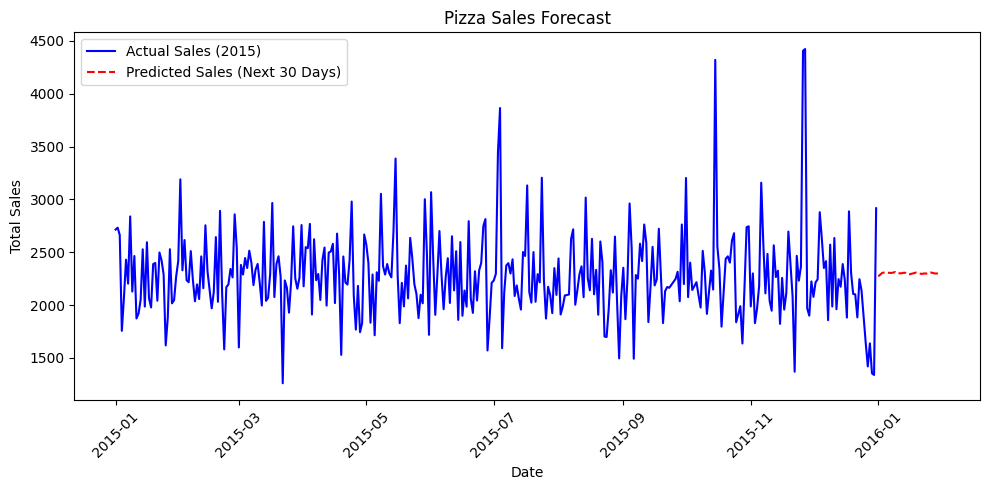

In [189]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Convert order_date to datetime
df['order_date'] = pd.to_datetime(df['order_date'])

# Aggregate daily total sales
daily_sales = df.groupby('order_date').agg(
    total_sales=('total_price', 'sum'),
    total_quantity=('quantity', 'sum')
).reset_index()

# Feature engineering for daily data
daily_sales['day'] = daily_sales['order_date'].dt.day
daily_sales['month'] = daily_sales['order_date'].dt.month
daily_sales['year'] = daily_sales['order_date'].dt.year
daily_sales['weekday'] = daily_sales['order_date'].dt.weekday

# Add lag features
daily_sales['lag_1'] = daily_sales['total_sales'].shift(1)  # Yesterday's sales
daily_sales['lag_7'] = daily_sales['total_sales'].shift(7)  # Sales from a week ago

# Fill NaNs from shifting
daily_sales.fillna(0, inplace=True)

# Prepare feature matrix (X) and target variable (y)
X = daily_sales[['day', 'month', 'year', 'weekday', 'total_quantity', 'lag_1', 'lag_7']]
y = daily_sales['total_sales']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, max_depth=5, learning_rate=0.05)
model.fit(X_train, y_train)

# Predict test data
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae}')

# Predict next 30 days
future_dates = pd.date_range(daily_sales['order_date'].max(), periods=31, freq='D')[1:]
future_features = pd.DataFrame({
    'day': future_dates.day,
    'month': future_dates.month,
    'year': future_dates.year,
    'weekday': future_dates.weekday,
    'total_quantity': np.mean(daily_sales['total_quantity']),  # Use avg past quantity
    'lag_1': daily_sales['total_sales'].iloc[-1],  # Last known sales
    'lag_7': daily_sales['total_sales'].iloc[-7]   # Sales from last week
})

# Predict future sales
future_sales = model.predict(future_features)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(daily_sales['order_date'], daily_sales['total_sales'], label='Actual Sales (2015)', color='blue')
plt.plot(future_dates, future_sales, label='Predicted Sales (Next 30 Days)', color='red', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Pizza Sales Forecast')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
